# Câu hỏi: **M08GEN01**
### Động lực:
Trong những năm gần đây, Text Generation với mô hình Transformer (chỉ Decoder) đã trở nên cực kỳ phổ biến và có thể dễ dàng thấy trong các công cụ như ChatGPT, Gemini, Grok,... Câu hỏi này yêu cầu hiểu biết về mô hình Transformer và cách nó dự đoán từ tiếp theo trong quá trình sinh văn bản.

### Mô tả
Hình ảnh minh hoạ đơn giản cho quá trình sinh từ bằng mô hình Transformer chỉ sử dụng Decoder. Cho trước một câu gồm một vài từ là "all in", sau khi tiền  xử lý, ta nhận được `input_ids`. Sau đó, tiến hành embed và truyền vào Decoder Transformer có kiến trúc như hình, output trả về tiếp tục được truyền vào Linear và nhận được một ma trận 3x6 như hình dưới.

### Câu hỏi
Bằng kiến thức đã học, bạn hãy tiếp tục xử lý output trên và cho biết token kế tiếp được sinh ra là?

### Chọn đáp án
A. \<eos>

B. all

C. in

D. one

### Đáp án: all

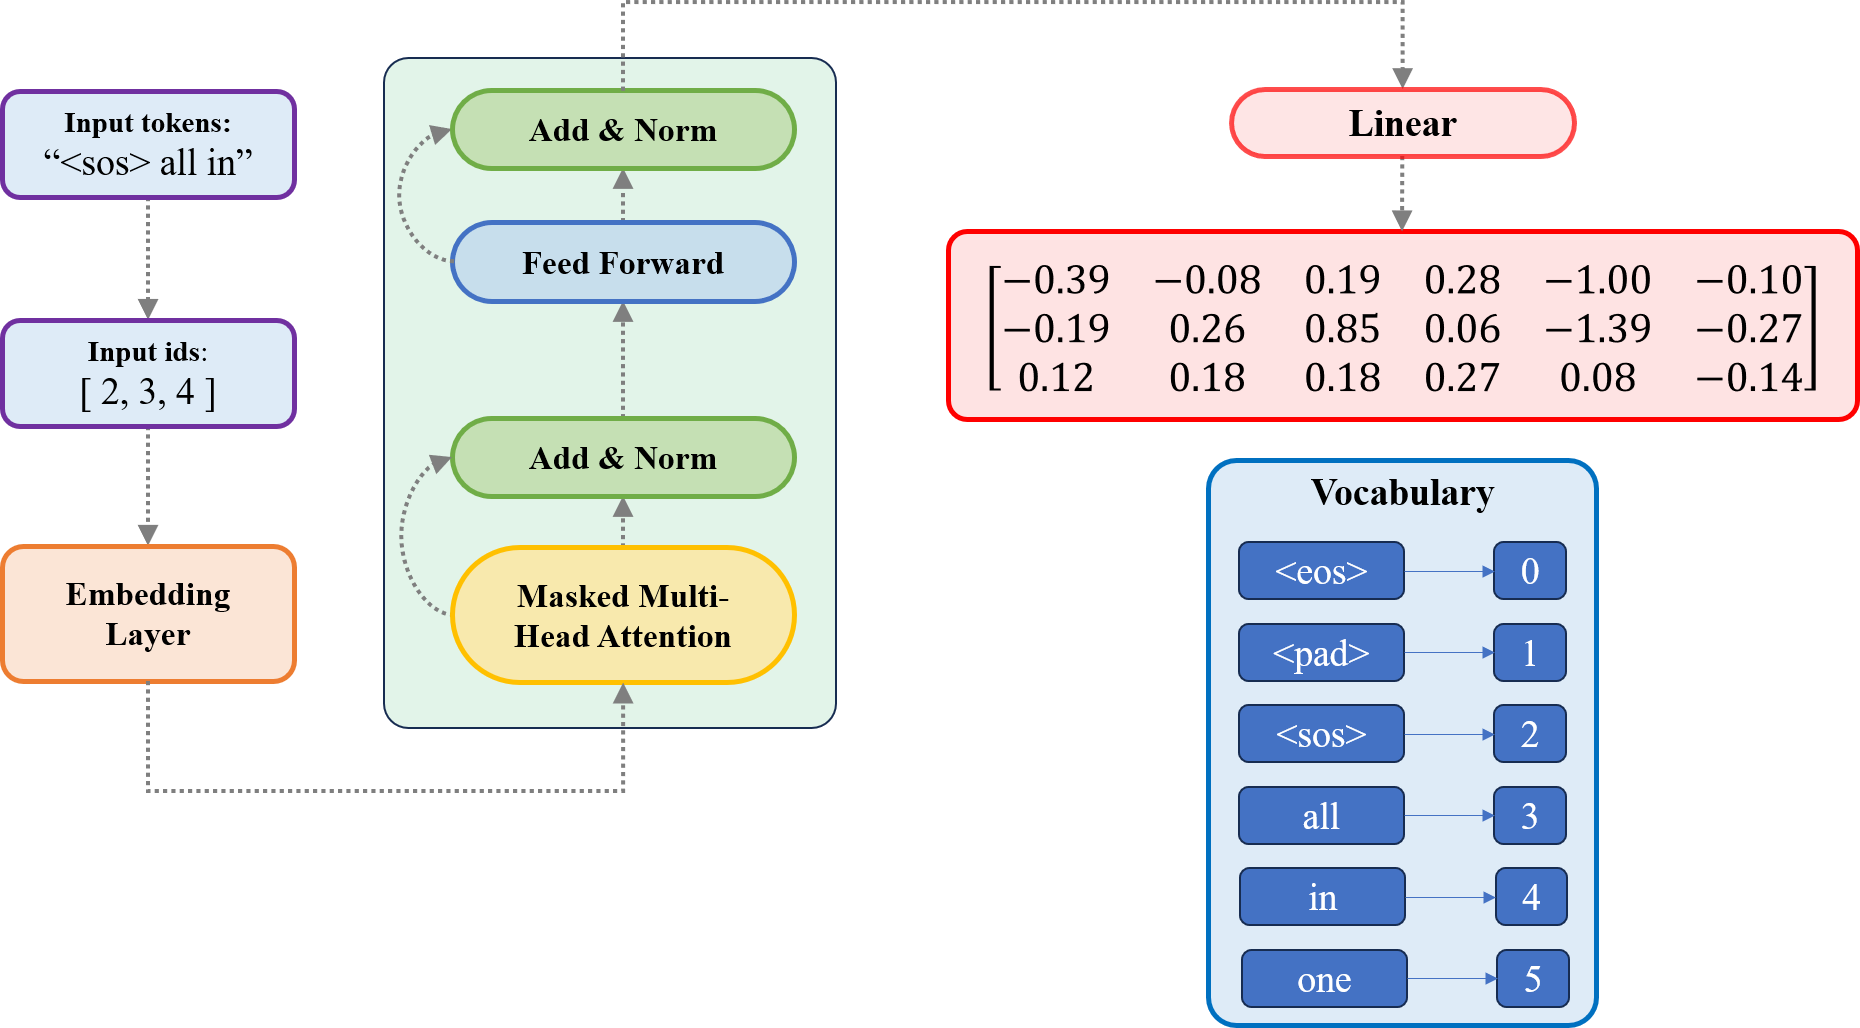

# Code

### **1. Library**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
print(f"Seed: {seed}")

Seed: 42


### **2. Corpus**

In [ ]:
# Tạo corpus
corpus = [
    "all in one",
]
print("Corpus:", corpus)

Corpus: ['all in one']


### **3. Preprocessing**

In [ ]:
# Tiền xử lý:
def preprocess_corpus(corpus, add_special=True):
    tokenized_corpus = []
    for sentence in corpus:
        sentence = sentence.lower()
        tokens = sentence.split()
        if add_special:
            tokens = ["<sos>"] + tokens + ["<eos>"]
        tokenized_corpus.append(tokens)

    vocab_set = set()
    for tokens in tokenized_corpus:
        vocab_set.update(tokens)

    if "<pad>" not in vocab_set:
        vocab_set.add("<pad>")

    sorted_vocab = sorted(list(vocab_set))
    token2id = {tok: idx for idx, tok in enumerate(sorted_vocab)}
    id2token = {idx: tok for idx, tok in enumerate(sorted_vocab)}

    all_ids = []
    for tokens in tokenized_corpus:
        ids = [token2id[t] for t in tokens]
        all_ids.append(ids)

    return all_ids, token2id, id2token

token_ids_list, token2id, id2token = preprocess_corpus(corpus)
print("Vocab size:", len(token2id))
print("token2id:", token2id)
print("Token IDs list:", token_ids_list)

Vocab size: 6
token2id: {'<eos>': 0, '<pad>': 1, '<sos>': 2, 'all': 3, 'in': 4, 'one': 5}
Token IDs list: [[2, 3, 4, 5, 0]]


### **4. Input**

In [ ]:
# Lấy riêng câu "all in one" làm input
one_for_all_ids = token_ids_list[0]
input_ids = torch.tensor([one_for_all_ids])
print("Input IDs:", input_ids)

Input IDs: tensor([[2, 3, 4, 5, 0]])


### **5. Decoder**

In [ ]:
# Định nghĩa mô hình Decoder
class SimpleDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_ff):
        super(SimpleDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Linear(dim_ff, d_model)
        )

    def forward(self, x, tgt_mask=None):
        attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x, attn_weights

# Định nghĩa mô hình
d_model = 4
vocab_size = len(token2id)
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

# Khởi tạo 1 layer Decoder
d_ff = 8
n_head = 2
decoder_layer = SimpleDecoderLayer(d_model, n_head, d_ff)
final_linear = nn.Linear(d_model, vocab_size)

### **6. Forward**

In [ ]:
# Tạo causal mask
seq_len = input_ids.size(1)
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
print("Causal mask:\n", mask)

Causal mask:
 tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [ ]:
# Forward qua Decoder
with torch.no_grad():
  embedded_input = embedding_layer(input_ids)
  decoder_output, attn_weights = decoder_layer(embedded_input, tgt_mask=mask)
  logits = final_linear(decoder_output)

print("Decoder Output (shape):", decoder_output.shape)
print("Decoder Output (values):\n", decoder_output)
print("Attention Weights (shape):", attn_weights.shape)
print("Attention Weights (values):\n", attn_weights)
print("Logits (shape):", logits.shape)
print("Logits (values):\n", logits)

Decoder Output (shape): torch.Size([1, 5, 4])
Decoder Output (values):
 tensor([[[ 1.1482, -1.0511, -0.9352,  0.8381],
         [ 0.3319,  0.9154, -1.6899,  0.4426],
         [ 0.0067, -0.4413,  1.5794, -1.1448],
         [-0.0074,  0.5734, -1.6079,  1.0419],
         [ 1.0080,  0.7148, -0.1582, -1.5646]]])
Attention Weights (shape): torch.Size([1, 5, 5])
Attention Weights (values):
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3547, 0.6453, 0.0000, 0.0000, 0.0000],
         [0.3277, 0.2441, 0.4282, 0.0000, 0.0000],
         [0.2520, 0.2859, 0.2064, 0.2557, 0.0000],
         [0.1608, 0.2833, 0.2502, 0.2254, 0.0803]]])
Logits (shape): torch.Size([1, 5, 6])
Logits (values):
 tensor([[[-0.3880, -0.0817,  0.1866,  0.2756, -1.0000, -0.1017],
         [-0.1907,  0.2572,  0.8523,  0.0648, -1.3870, -0.2662],
         [ 0.1187,  0.1754,  0.1813,  0.2735,  0.0785, -0.1382],
         [-0.4064,  0.1873,  0.5258,  0.1664, -1.0185, -0.4481],
         [ 0.3958,  0.3207,  1.1311, -0.

### **7. Text Generation**

In [ ]:
# Mô phỏng sinh text
def generate_text(current_ids, max_steps=1):
    with torch.no_grad():
      for step in range(max_steps):
          print("*" * 30, f"Step {step+1}", "*" * 30)
          seq_len_cur = len(current_ids)

          emb = embedding_layer(current_ids)
          print("=" * 10, "Embedding", "=" * 10)
          print(emb)

          causal_mask = torch.triu(torch.ones(seq_len_cur, seq_len_cur), diagonal=1).bool()
          print("=" * 10, "Causal Mask", "=" * 10)
          print(causal_mask)

          out, _ = decoder_layer(emb, tgt_mask=causal_mask)
          print("=" * 10, "Decoder Output", "=" * 10)
          print(out)

          logits_step = final_linear(out)
          logits_step = torch.round(logits_step, decimals=2)
          print("=" * 10, "Logits", "=" * 10)
          print(logits_step)

          last_logits = logits_step[-1, :]
          print("=" * 10, "Last Logits", "=" * 10)
          print(last_logits)

          next_id = torch.argmax(last_logits, dim=-1, keepdim=True)
          print("=" * 10, "Next ID", "=" * 10)
          print(next_id)

          current_ids = torch.cat([current_ids, next_id])
          print("=" * 10, "Current IDs", "=" * 10)
          print(current_ids)

          predicted_token = [k for k,v in token2id.items() if v == next_id.item()][0]
          print("=" * 10, "Predicted Token", "=" * 10)
          print(predicted_token)
    return current_ids

# Demo sinh thêm 1 token sau câu "all in"
print("=== Demo Generation Loop ===")
print("Text:", corpus[0])

new_input_ids = input_ids[0][:-2]
detoken = " ".join([id2token[id] for id in input_ids[0].tolist()])
new_detoken = " ".join([id2token[id] for id in new_input_ids.tolist()])
print("Groundtruth:", detoken)
print("Input after pre-processing:", new_detoken)

print("Groundtruth:", input_ids)
print("New Input IDs:", new_input_ids)

max_steps = 1
_ = generate_text(new_input_ids, max_steps=max_steps)


=== Demo Generation Loop ===
Text: all in one
Groundtruth: <sos> all in one <eos>
Input after pre-processing: <sos> all in
Groundtruth: tensor([[2, 3, 4, 5, 0]])
New Input IDs: tensor([2, 3, 4])
****************************** Step 1 ******************************
========== Embedding ==========
tensor([[ 0.3559, -0.6866, -0.4934,  0.2415],
        [-1.1109,  0.0915, -2.3169, -0.2168],
        [-0.3097, -0.3957,  0.8034, -0.6216]])
========== Causal Mask ==========
tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])
========== Decoder Output ==========
tensor([[ 1.1482, -1.0511, -0.9352,  0.8381],
        [ 0.3319,  0.9154, -1.6899,  0.4426],
        [ 0.0067, -0.4413,  1.5794, -1.1448]])
========== Logits ==========
tensor([[-0.3900, -0.0800,  0.1900,  0.2800, -1.0000, -0.1000],
        [-0.1900,  0.2600,  0.8500,  0.0600, -1.3900, -0.2700],
        [ 0.1200,  0.1800,  0.1800,  0.2700,  0.0800, -0.1400]])
========== Last Logits ==========
tenso